<img align="right" src="../../additional_data/banner.png" style="width:1100px;">

# Forest inventory

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg
* **Prerequisites**: Users should review the [mosaic-](mosaic.ipynb), [export_geotiff-](export_geotiff.ipynb) notebook for more information about the basic steps for any given temporal and spatial combination. Further, knowledge about working with SQL can be useful. An understanding of the underlying data is important for creating a valid mosaic for further analyses.

### Background

Forests are complex biomes. Anaylzing them is an important task to enhance the understanding, also in the context of the current global change. Forests have an important role, e.g. econmical or as carbon sink, which can also be conenected to monetary aspects (CO2 certificates). Furhter societal benefits are in the context of healthcare, e.g. allergies or considering upcoming zoonoses like the Covid-19 pandemic as well as forests role in recreation.


This example tries to demonstrate a potential workflow from loading and processing (cloud removal, median-mosaicing, index calculation) satellite raster-data togehter with additional on-demand vector-data nd export them as cloud-optimized-geotiff for individual processing, e.g. in a local GIS.

### Preliminary steps

In [1]:
# Supress Warning
import warnings
warnings.filterwarnings('ignore')
# Import (geo)pandas package with shortcut (g)pd
import pandas as pd
import geopandas as gpd
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'forest_inventory', config = '/home/datacube/.datacube.conf')
import sys
from dask.distributed import Client

In [2]:
from dask.distributed import LocalCluster

In [4]:
cluster = LocalCluster()

In [5]:
client = Client(cluster)

In [6]:
client

Client Scheduler: tcp://127.0.0.1:46175 Dashboard: http://127.0.0.1:43333/status,Cluster Workers: 8 Cores: 40 Memory: 190.15 GB


### Loading your area of interest as sahepfile (here: different conservation zones in Rhoen Highlands)

In [148]:
#rhoen = gpd.read_file('MDPI/ONE/biosphaerenreservate_epsg25832_shp.shp')

In [7]:
rhoen = gpd.read_file('../../additional_data/rhoen.geojson')

### Alternative load data from PostGIS (spatial PostgreSQL-extension)

In [8]:
# database API
import psycopg2
# PostGIS connection credentials
user = 'dc_user'
password = 'localuser1234'
host = '127.0.0.1'
port = '5432'
database = 'datacube'

In [9]:
# 1. open connection first, 2. write data, 3. close afterwards
connection = psycopg2.connect(database=database, user=user, password=password, host=host)

# Forest inventory data downloaded: 'GFs_ReinbestandGattung_mitSp_PolyVar'
# see https://bwi.info/

# sql statement looking for 'geom, tnr, pquerus (percent share oak), pfagus (percent share beech), pfraxinus (percent share ash), 
# pabies (percent share fir)  ppicea (percent share spruce), ppinus (percetn share pine)'
forest_inventory = gpd.GeoDataFrame.from_postgis("SELECT * FROM etrs89_bwi_2012p;", connection)
attributes =pd.read_sql_query("SELECT  column_name FROM information_schema.columns WHERE table_name = 'etrs89_bwi_2012p';",con=connection)
forest = gpd.GeoDataFrame.from_postgis("SELECT * FROM etrs89_bwi_2012p WHERE tnr > 16617 AND tnr < 16623 ;", connection)
tr_nr_16086 = gpd.GeoDataFrame.from_postgis("SELECT geom, tnr, pquerus, pfagus, pfraxinus, pabies, ppicea, ppinus FROM etrs89_bwi_2012p WHERE tnr = 16086 ;", connection)


connection.close()

attributes = attributes.column_name
attributes = list(attributes)
attributes.remove('geom')

forest_inventory_wgs = forest_inventory.to_crs('EPSG:4326')
forest_wgs = forest.to_crs('EPSG:4326')
#forest_inventory

In [10]:
import folium

# define polygon style
style = {'fillColor': '#ffffffff', 'color': '#000000'}

# open map 'm' with defined center and zomm level
m = folium.Map([50, 10.5], zoom_start=12)#, tiles='Stamen Terrain')

# load esris satellite map
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

# add geojson
#folium.GeoJson(forest_inventory_wgs, style_function=lambda x: style, name="bwi",
 #                            tooltip=folium.features.GeoJsonTooltip(fields=attributes, localize=True)).add_to(m)
#folium.GeoJson(rhoen, name="Rhoen").add_to(m)

folium.GeoJson(tr_nr_16086, name="16086", tooltip=folium.features.GeoJsonTooltip(fields=["ppicea","pfagus","tnr"], localize=True)).add_to(m)


# load openstreet map
folium.TileLayer('openstreetmap').add_to(m)

# load terrain map
folium.TileLayer('Stamen Terrain').add_to(m)

# add lat/lon popup after click on maps
#folium.LatLngPopup().add_to(m)

#
#folium.ClickForMarker().add_to(m)
# open layer control in upper right corner of the map
folium.LayerControl().add_to(m)
m

## Load Sentinel-2 data from the datacube

Here we are loading a timeseries of `Sentinel-2` satellite images through the datacube API.(official coordinate system ['EPSG:25832'](https://www.ldbv.bayern.de/file/pdf/12867/Faltblatt_UTM-Umstellung.pdf))

In [ ]:
# for testing tile intersections

In [182]:
quad = gpd.read_file('../../additional_data/upa_uqa_upv_uqv.geojson')

minx = quad.bounds.iloc[0,0]
maxx = quad.bounds.iloc[0,2]
miny = quad.bounds.iloc[0,1]
maxy = quad.bounds.iloc[0,3]


In [ ]:
quad

In [11]:
# writing query extents from inventory tract
minx = tr_nr_16086.bounds.iloc[0,0]
maxx = tr_nr_16086.bounds.iloc[0,2]
miny = tr_nr_16086.bounds.iloc[0,1]
maxy = tr_nr_16086.bounds.iloc[0,3]

In [12]:
# Create query variables
product = 's2_l2a_bavaria'
x_min = minx
x_max = maxx
y_min = miny
y_max = maxy
cosy = 'EPSG:25832'
time_extent = ('2015-01-01', '2021-03-31')

Loading may take a few minutes

In [13]:
# Lazy load data using dask-chunks
dataset = dc.load(product=product,
                  y= (y_min, y_max),
                  x=(x_min, x_max),
                  crs=cosy,
                  time=time_extent)#,
#                  dask_chunks={"time": 1, "x": 100, "y": 100})

Apply a Sentinel-2 scene classification (scl-band) for masking clouds

In [15]:
scl_val = {'0': 'no_data','1': 'defect','2': 'dark','3': 'cloud_shadow',
    '4': 'vegetation','5': 'no_vegetation','6': 'water','7': 'no_class',
    '8': 'cloud_med_prob','9': 'cloud_high_prob','10': 'cirrus','11': 'snow'}

def s2_mask(dataset, values = ['vegetation','no_vegetation','water','snow']):
        return dataset["scl"].isin([int(i) for i,j in scl_val.items() if j in values])
    
mask = s2_mask(dataset)
mask_num = mask.astype('uint8')
dataset['mask'] = mask_num

#dataset_backup = dataset

In [82]:
# percent share of clouds, 0.001 = 0.1 %
cloud_percent = 0.001
    
clean_dataset=dataset.sel(time=pd.to_datetime(
((dataset.sum(dim=['x','y'])/
  ((dataset.dims)['y']*(dataset.dims)['x']))
 .time.where(
     ((dataset.sum(dim=['x','y'])/
  ((dataset.dims)['y']*(dataset.dims)['x'])).mask) > cloud_percent,drop=True))
.values.tolist()))

In [317]:
clean_dataset

<xarray.Dataset>
Dimensions:          (time: 503, x: 227, y: 227)
Coordinates:
  * time             (time) datetime64[ns] 2015-07-30T10:30:16 ... 2021-03-27...
  * y                (y) float64 5.546e+06 5.546e+06 ... 5.543e+06 5.543e+06
  * x                (x) float64 6.03e+05 6.03e+05 ... 6.052e+05 6.052e+05
    spatial_ref      int32 25832
Data variables:
    coastal_aerosol  (time, y, x) float64 385.0 385.0 385.0 ... nan nan nan
    blue             (time, y, x) float64 298.0 338.0 311.0 ... nan nan nan
    green            (time, y, x) float64 507.0 502.0 498.0 ... nan nan nan
    red              (time, y, x) float64 261.0 293.0 267.0 ... nan nan nan
    red_edge1        (time, y, x) float64 891.0 898.0 898.0 ... nan nan nan
    red_edge2        (time, y, x) float64 3.491e+03 3.151e+03 ... nan nan
    red_edge3        (time, y, x) float64 4.495e+03 3.951e+03 ... nan nan
    nir              (time, y, x) float64 4.944e+03 4.28e+03 ... nan nan
    narrow_nir       (time, y, x) float64 4.905e+03 4.377e+03 ... nan nan
    water_vapour     (time, y, x) float64 3.926e+03 3.926e+03 ... nan nan
    swir1            (time, y, x) float64 1.848e+03 1.757e+03 ... nan nan
    swir2            (time, y, x) float64 763.0 785.0 785.0 ... nan nan nan
    scl              (time, y, x) float64 4.0 4.0 4.0 4.0 ... nan nan nan nan
    mask             (time, y, x) float64 1.0 1.0 1.0 1.0 ... nan nan nan nan
    ndvi8a           (time, y, x) float64 0.899 0.8745 0.885 ... nan nan nan
    evi              (time, y, x) float64 2.74 2.835 2.817 2.763 ... nan nan nan
    nirv             (time, y, x) float64 4.905e+03 4.377e+03 ... nan nan
    clr              (time, y, x) float64 3.603e+03 3.052e+03 ... nan nan
    clg              (time, y, x) float64 3.987e+03 3.448e+03 ... nan nan
    ndre1            (time, y, x) float64 1.459 1.254 1.254 ... nan nan nan
    ndre2            (time, y, x) float64 0.6925 0.6595 0.6595 ... nan nan nan
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

### Create a test dataset

In [85]:
NDVI8A = (dataset.narrow_nir - dataset.red)/(dataset.narrow_nir + dataset.red)
#NDVI8 = (dataset.nir - dataset.red)/(dataset.nir + dataset.red)
#NDWI8 = (dataset.nir - dataset.swir2)/(dataset.nir + dataset.swir2)
NDWI8A = (dataset.narrow_nir - dataset.swir2)/(dataset.narrow_nir + dataset.swir2)
#
EVI = (2.5 * (dataset.narrow_nir - dataset.red))/(dataset.narrow_nir + 6 * dataset.red - 7.5 * dataset.blue + 1)
#
NIRv = ((dataset.narrow_nir - dataset.red) / (dataset.narrow_nir - dataset.red))*dataset.narrow_nir
#
Clr = ((dataset.red_edge3 - dataset.red_edge1)-1)
#
Clg = ((dataset.red_edge3 - dataset.green)-1)
#
MTCI = (dataset.red_edge2 - dataset.red_edge1)/(dataset.red_edge1 - dataset.red)
#
NDRE1 = (dataset.red_edge2 - dataset.red_edge1)/(dataset.red_edge1 + dataset.red_edge1)
#
NDRE2 = (dataset.narrow_nir - dataset.red_edge1)/(dataset.narrow_nir + dataset.red_edge1)

dataset['ndvi8a'] = NDVI8A

#dataset['ndvi8'] = NDVI8
#dataset['ndwi8a'] = NDWI8A
dataset['evi'] = EVI
#
dataset['nirv'] = NIRv
#
dataset['clr'] = Clr
#
dataset['clg'] = Clg
#
dataset['ndre1'] = NDRE1
#
dataset['ndre2'] = NDRE2

### Plot an rgb image to make sure we have data

The 'time' dimension above shows the number of observations and is also the range that can be choosen, considering that Python starst counting with `0`.

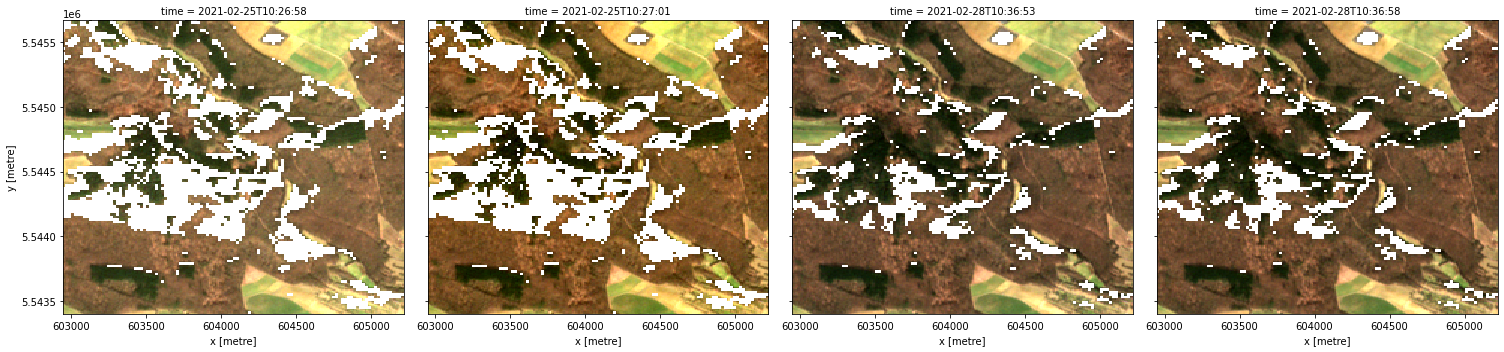

In [99]:
sys.path.append('/datacube/data_cube_notebooks/datacube/Scripts')
from DEAPlotting import rgb

#rgb(clean_dataset.sel(time=slice('2015-07-01', '2015-08-31')).compute(), 
 #   index=[0,1,2,3,4,5,6], percentile_stretch=(0.01, 0.99), size=8)
rgb(clean_dataset, index=[14,15,16,17], size = 5, percentile_stretch=(0.01, 0.99))

## Calculating cloud share
Loading needed functions first

In [ ]:
# define which dataset you want to use for the cloud table


In [185]:
# write the prepared dataset using s2_mask() above
times = list(dataset.time.values)
percentage_list = list((((dataset.sum(dim=['x','y'])/
                          ((dataset.dims)['y']*(dataset.dims)['x']))
                        .mask).values)*100)
data = {"Acquisition time": times,
            "Cloud free pixel[%]": percentage_list}
s2_cct = pd.DataFrame(data=data, columns = ["Acquisition time", "Cloud free pixel[%]"])
s2_cct

,Acquisition time,Cloud free pixel[%]
0,2015-07-04 10:13:37,0.000000
1,2015-07-24 10:10:08,0.000000
2,2015-07-30 10:30:16,58.869763
3,2015-08-03 10:10:10,0.000000
4,2015-08-06 10:20:12,49.391605
...,...,...
1334,2021-03-27 10:26:56,0.450232
1335,2021-03-27 10:26:58,0.426944
1336,2021-03-27 10:27:03,0.000000
1337,2021-03-27 10:27:05,0.000000


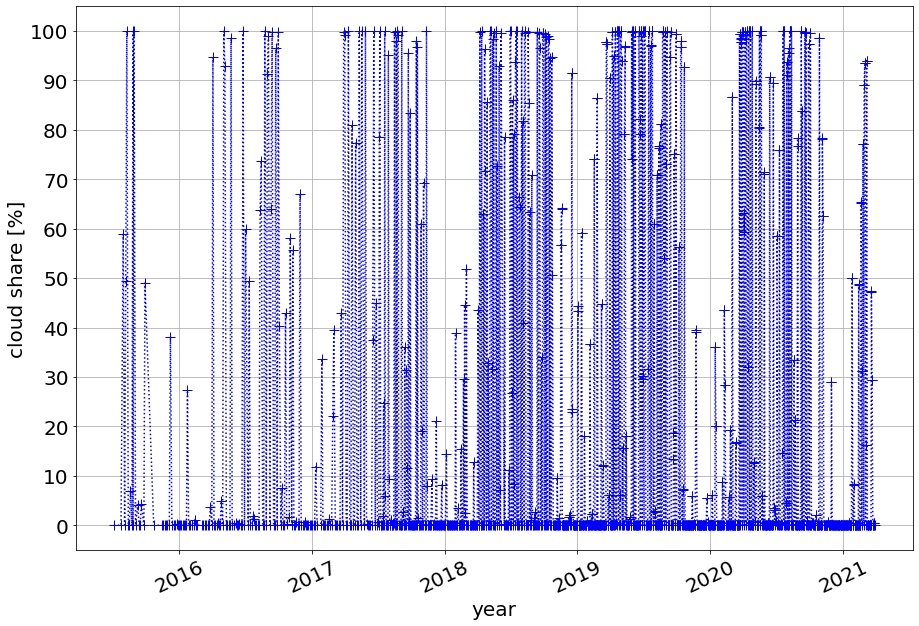

In [187]:
import matplotlib.pyplot as plt
cct = s2_cct

plt.figure(figsize = (15,10))
plt.plot(cct["Acquisition time"], cct["Cloud free pixel[%]"], 'b+:', markersize=10)
#x_ticks = np.arange(20000, 20200, 50)
plt.xticks(rotation=25,size=20,)
plt.yticks(list(range(0,109,10)),size=20)
plt.ylabel('cloud share [%]', size=20)
plt.xlabel('year', size=20)
plt.grid(True)

plt.savefig('tract16086_15_21.png')
plt.show()

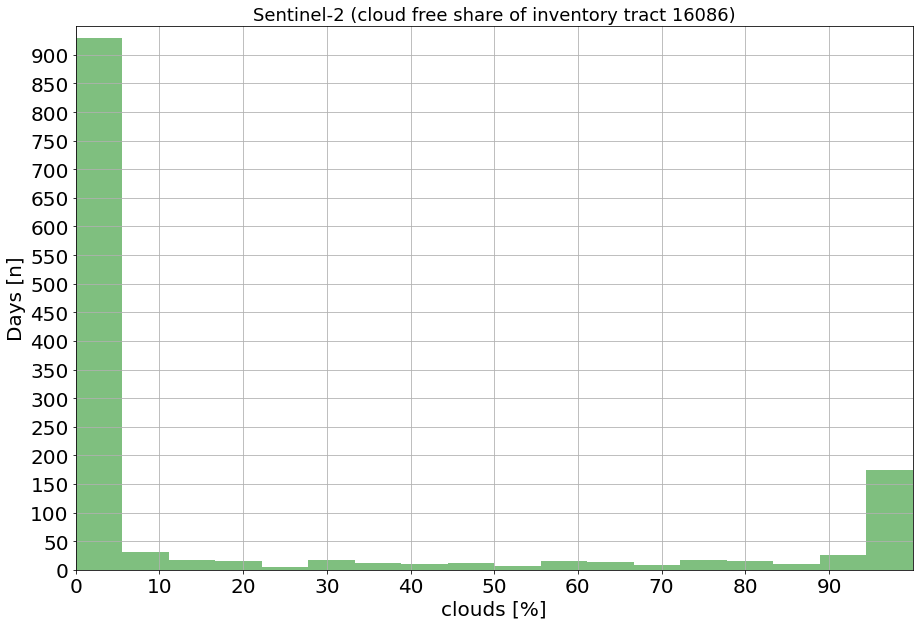

In [193]:
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.figure(figsize = (15,10))
#plt.scatter(cloud_table["times"].values, cloud_table["clean_percentage"].values)
plt.hist(cct["Cloud free pixel[%]"], 18, facecolor='g', alpha=.5)
plt.title('Sentinel-2 (cloud free share of inventory tract 16086)', size='18')# ( '+ 
#          np.datetime_as_string(dataset.time[0].values).split('T')[0] + " to " +
 #         np.datetime_as_string(dataset.time[-1].values).split('T')[0] + ")", 
  #        size='18')

plt.xlabel('clouds [%]', size=20)
plt.ylabel('Days [n]', size=20)
plt.yticks(list(range(0,950,50)),size='20')
plt.xticks(list(range(0,100,10)),size='20')
plt.axis([0,100, 0, 950])
plt.grid(True)
plt.savefig('cloud_tract16086.png')
plt.show()

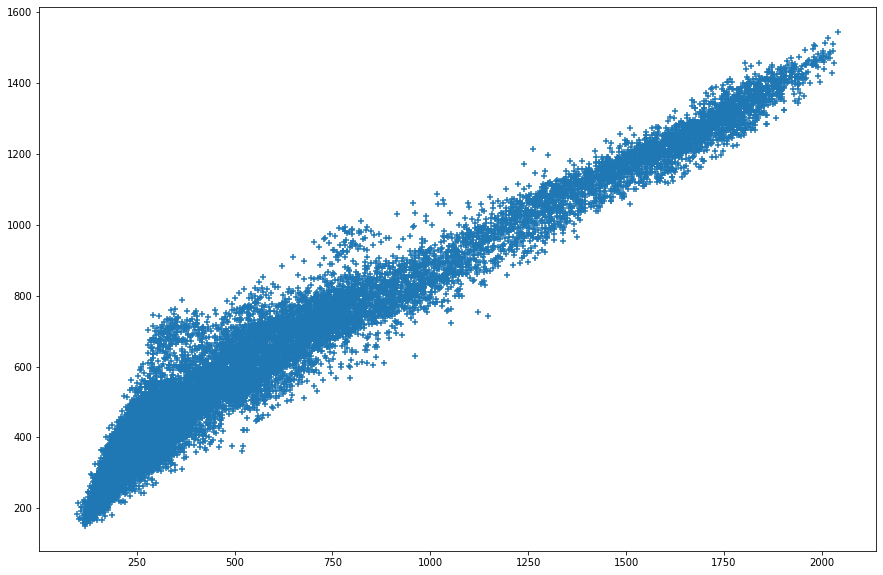

In [203]:
plt.figure(figsize = (15,10))
plt.scatter(clean_dataset.isel(time=[300]).red, clean_dataset.isel(time=[300]).green, marker = '+')

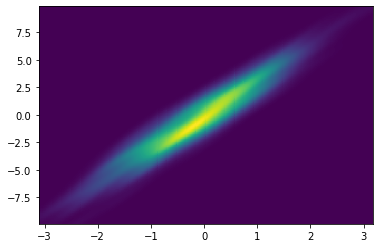

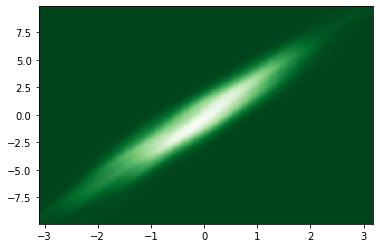

In [248]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
 
# create data
x = np.random.normal(size=500)
y = x * 3 + np.random.normal(size=500)
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
plt.show()
 
# Change color palette
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.Greens_r)
plt.show()

In [297]:
clean_dataset.data

AttributeError: 'Dataset' object has no attribute 'data'

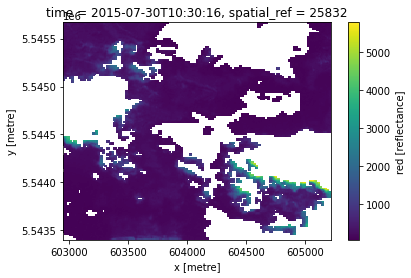

In [291]:
clean_dataset.isel(time=0).red.plot()

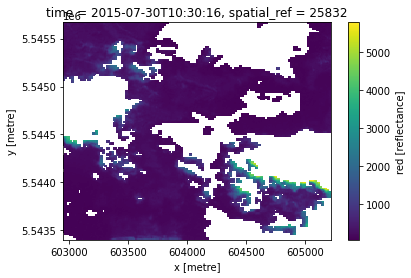

In [290]:
clean_dataset.red.isel(time=0).plot()

In [311]:
clean_dataset.isel(time=0).red.values

array([[261., 293., 267., ..., 121., 119., 119.],
       [263., 283., 257., ..., 119., 120., 119.],
       [287., 279., 267., ..., 111., 114., 120.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [315]:
clean_dataset.isel(time=0).red.x

[<xarray.DataArray 'x' ()>
 array(602955.)
 Coordinates:
     time         datetime64[ns] 2015-07-30T10:30:16
     x            float64 6.03e+05
     spatial_ref  int32 25832
 Attributes:
     units:       metre
     resolution:  10.0
     crs:         EPSG:25832,
 <xarray.DataArray 'x' ()>
 array(602965.)
 Coordinates:
     time         datetime64[ns] 2015-07-30T10:30:16
     x            float64 6.03e+05
     spatial_ref  int32 25832
 Attributes:
     units:       metre
     resolution:  10.0
     crs:         EPSG:25832,
 <xarray.DataArray 'x' ()>
 array(602975.)
 Coordinates:
     time         datetime64[ns] 2015-07-30T10:30:16
     x            float64 6.03e+05
     spatial_ref  int32 25832
 Attributes:
     units:       metre
     resolution:  10.0
     crs:         EPSG:25832,
 <xarray.DataArray 'x' ()>
 array(602985.)
 Coordinates:
     time         datetime64[ns] 2015-07-30T10:30:16
     x            float64 6.03e+05
     spatial_ref  int32 25832
 Attributes:
     units:      

In [306]:
clean_dataset.isel(time=0).red

<xarray.DataArray 'red' (y: 227, x: 227)>
array([[261., 293., 267., ..., 121., 119., 119.],
       [263., 283., 257., ..., 119., 120., 119.],
       [287., 279., 267., ..., 111., 114., 120.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
    time         datetime64[ns] 2015-07-30T10:30:16
  * y            (y) float64 5.546e+06 5.546e+06 ... 5.543e+06 5.543e+06
  * x            (x) float64 6.03e+05 6.03e+05 6.03e+05 ... 6.052e+05 6.052e+05
    spatial_ref  int32 25832
Attributes:
    units:         reflectance
    nodata:        0
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

In [289]:
type(clean_dataset.isel(time=0).red.values)

numpy.ndarray

In [273]:
type(clean_dataset.red)

xarray.core.dataarray.DataArray

In [288]:
x = np.random.normal(size=500)
type(x)
x

array([-6.97578663e-01, -4.93534000e-01, -9.41918822e-02, -9.91114083e-01,
       -1.14821810e+00,  1.29636234e+00,  5.51504458e-01,  1.01432544e+00,
       -7.15846473e-01, -4.16664216e-01, -3.06166999e-01,  9.56293759e-01,
       -1.35224825e+00, -8.25940263e-01,  1.37865666e-01,  8.21882215e-01,
        1.45899152e+00,  1.15437978e+00, -2.13418532e+00, -1.14775210e+00,
        1.16858808e+00, -1.15218792e+00, -1.09961308e+00,  1.96333272e+00,
       -1.24751444e+00,  7.76887588e-01,  2.90921587e-01, -1.40713093e-01,
       -1.05136089e+00, -5.15529992e-01,  1.01228990e+00, -1.25219476e-01,
        1.52911798e-01, -1.12423028e-01, -8.56091589e-01,  4.88745764e-01,
        1.09277600e+00, -4.80746514e-01,  4.68383721e-01,  1.01525380e+00,
        5.46264005e-01, -1.66989218e+00, -8.87315689e-01,  7.47271214e-01,
       -3.04371678e-01,  2.42541084e-01,  1.55982212e+00, -2.55109647e-01,
       -8.21308394e-01,  4.77870586e-01, -1.15987545e+00, -8.09354786e-01,
        1.26758511e+00,  

In [276]:
kde.gaussian_kde([x,y])

ValueError: too many values to unpack (expected 2)

In [250]:
x = clean_dataset.isel(time=[300]).red.values

In [232]:
x

array([[[280., 284., 283., ..., 206., 215., 220.],
        [317., 295., 298., ..., 198., 200., 215.],
        [358., 327., 289., ..., 194., 207., 214.],
        ...,
        [493., 484., 514., ..., 735., 655., 601.],
        [502., 515., 532., ..., 722., 691., 634.],
        [523., 511., 566., ..., 653., 673., 680.]]])

In [244]:
color

{0.40540545442931486: 'red',
 0.5507273095839152: 'blue',
 0.8707083476825868: 'red',
 0.4903222828104042: 'blue',
 0.2522359048241747: 'blue',
 -0.0711348843743651: 'red',
 0.2959380554511573: 'red',
 0.5213752747123546: 'blue',
 0.4167005896956959: 'blue',
 0.5518696539053511: 'blue',
 0.310322748013643: 'red',
 -0.020189594446955783: 'red',
 0.3230857255289421: 'blue',
 0.43841441189531455: 'red',
 0.5160890709353672: 'red',
 0.7738664618245648: 'blue',
 0.9148367260776924: 'blue',
 0.16951856000876736: 'red',
 0.2841568810686902: 'red',
 0.3607406197710913: 'red',
 0.5068540139339651: 'red',
 0.3628235953346268: 'blue',
 0.6612939524964615: 'red',
 0.7366657495157825: 'blue',
 1.2834369495820166: 'blue',
 0.26253613365296263: 'red',
 0.5045682803697971: 'blue',
 1.1928322192566907: 'red',
 0.7250158699108007: 'red',
 0.5456332826382917: 'blue',
 0.4110409530213901: 'red',
 0.33954667379085374: 'blue',
 0.8357111862821498: 'red',
 0.5688697249377197: 'red',
 0.8280092014259152: 'blu

In [226]:
x = clean_dataset.isel(time=[300]).red

In [236]:
for i in x:
   if i not in color:
      color[i] = colors[random.randint(1, 10000) % len(colors)]

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
clean_dataset.isel(time=[300]).red

In [264]:
x = np.random.normal(0.5, 0.3, 10000)
x

array([ 0.08537633, -0.01823757,  1.11065132, ...,  0.76636079,
        0.29511699,  0.76105697])

In [225]:
color

{0.40540545442931486: 'red',
 0.5507273095839152: 'blue',
 0.8707083476825868: 'red',
 0.4903222828104042: 'blue',
 0.2522359048241747: 'blue',
 -0.0711348843743651: 'red',
 0.2959380554511573: 'red',
 0.5213752747123546: 'blue',
 0.4167005896956959: 'blue',
 0.5518696539053511: 'blue',
 0.310322748013643: 'red',
 -0.020189594446955783: 'red',
 0.3230857255289421: 'blue',
 0.43841441189531455: 'red',
 0.5160890709353672: 'red',
 0.7738664618245648: 'blue',
 0.9148367260776924: 'blue',
 0.16951856000876736: 'red',
 0.2841568810686902: 'red',
 0.3607406197710913: 'red',
 0.5068540139339651: 'red',
 0.3628235953346268: 'blue',
 0.6612939524964615: 'red',
 0.7366657495157825: 'blue',
 1.2834369495820166: 'blue',
 0.26253613365296263: 'red',
 0.5045682803697971: 'blue',
 1.1928322192566907: 'red',
 0.7250158699108007: 'red',
 0.5456332826382917: 'blue',
 0.4110409530213901: 'red',
 0.33954667379085374: 'blue',
 0.8357111862821498: 'red',
 0.5688697249377197: 'red',
 0.8280092014259152: 'blu

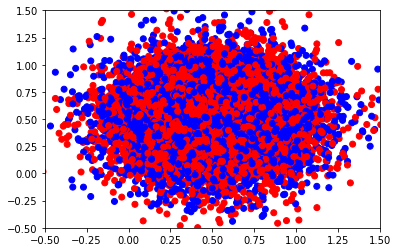

In [222]:
import random
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = np.random.normal(0.5, 0.3, 10000)
y = np.random.normal(0.5, 0.3, 10000)

colors = ['red', 'blue']

color = dict()
for i in x:
   if i not in color:
      color[i] = colors[random.randint(0, 100000) % len(colors)]

ax.scatter(x, y, c=[color.get(i) for i in x])

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)

plt.show()

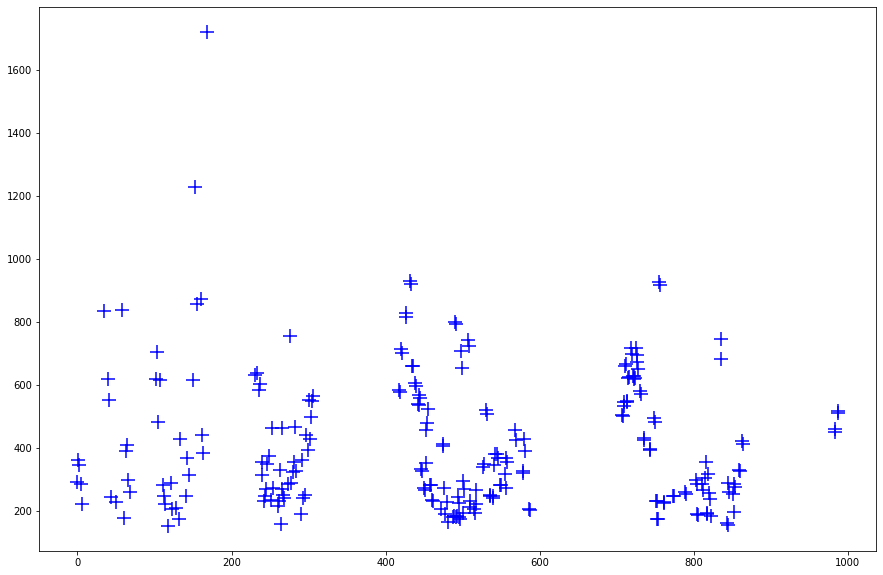

In [143]:
plt.figure(figsize = (15,10))
plt.scatter(zeiten,liste,  color="b", marker="+", s=200)

In [144]:
liste = list(cleaned_dataset.red.values[:,0,2])

In [109]:
print(range(10))

range(0, 10)


In [121]:
zeiten = []
for zeit in range(1005):
    zeiten.append(zeit)

In [123]:
zeiten

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


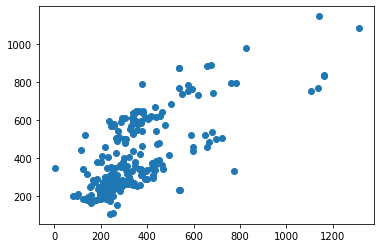

In [81]:
plt.scatter(cleaned_dataset.blue.values[:,0,0], cleaned_dataset.red.values[:,0,0])

In [ ]:
plt.figure(figsize = (15,10))

ax = plt.gca()

ax.scatter(zeiten, cleaned_dataset.blue.values[:,0,0] , color="b", s=5)
ax.scatter(zeiten, cleaned_dataset.red.values[:,0,0] , color="r")
ax.scatter(zeiten, cleaned_dataset.green.values[:,0,0] , color="g")
#ax.scatter(zeiten, cleaned_dataset.coastal_aerosol.values[:,0,0] , color="grey")
ax.scatter(zeiten, cleaned_dataset.red_edge1.values[:,0,0] , color="r", marker="1")
ax.scatter(zeiten, cleaned_dataset.red_edge2.values[:,0,0] , color="r", marker="2")
ax.scatter(zeiten, cleaned_dataset.red_edge3.values[:,0,0] , color="r", marker="3")

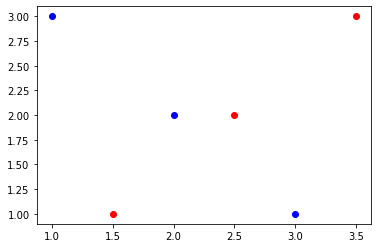

In [165]:
interclean = cleaned_dataset.compute()

In [175]:
interclean = interclean.interpolate_na(dim="time")

<xarray.Dataset>
Dimensions:          (time: 7, x: 227, y: 227)
Coordinates:
    spatial_ref      int32 25832
  * time             (time) datetime64[ns] 2015-07-30T10:30:16 ... 2015-08-29...
  * y                (y) float64 5.546e+06 5.546e+06 ... 5.543e+06 5.543e+06
  * x                (x) float64 6.03e+05 6.03e+05 ... 6.052e+05 6.052e+05
Data variables:
    coastal_aerosol  (time, y, x) float64 385.0 385.0 385.0 ... 320.0 320.0
    blue             (time, y, x) float64 298.0 338.0 311.0 ... 345.0 347.0
    green            (time, y, x) float64 507.0 502.0 498.0 ... 659.0 651.0
    red              (time, y, x) float64 261.0 293.0 267.0 ... 505.0 515.0
    red_edge1        (time, y, x) float64 891.0 898.0 ... 1.099e+03 1.099e+03
    red_edge2        (time, y, x) float64 3.491e+03 3.151e+03 ... 2.424e+03
    red_edge3        (time, y, x) float64 4.495e+03 3.951e+03 ... 2.817e+03
    nir              (time, y, x) float64 4.944e+03 4.28e+03 ... 2.728e+03
    narrow_nir       (time, y, x) float64 4.905e+03 4.377e+03 ... 3.075e+03
    water_vapour     (time, y, x) float64 3.926e+03 3.926e+03 ... 2.825e+03
    swir1            (time, y, x) float64 1.848e+03 1.757e+03 ... 2.606e+03
    swir2            (time, y, x) float64 763.0 785.0 ... 1.444e+03 1.444e+03
    scl              (time, y, x) float64 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

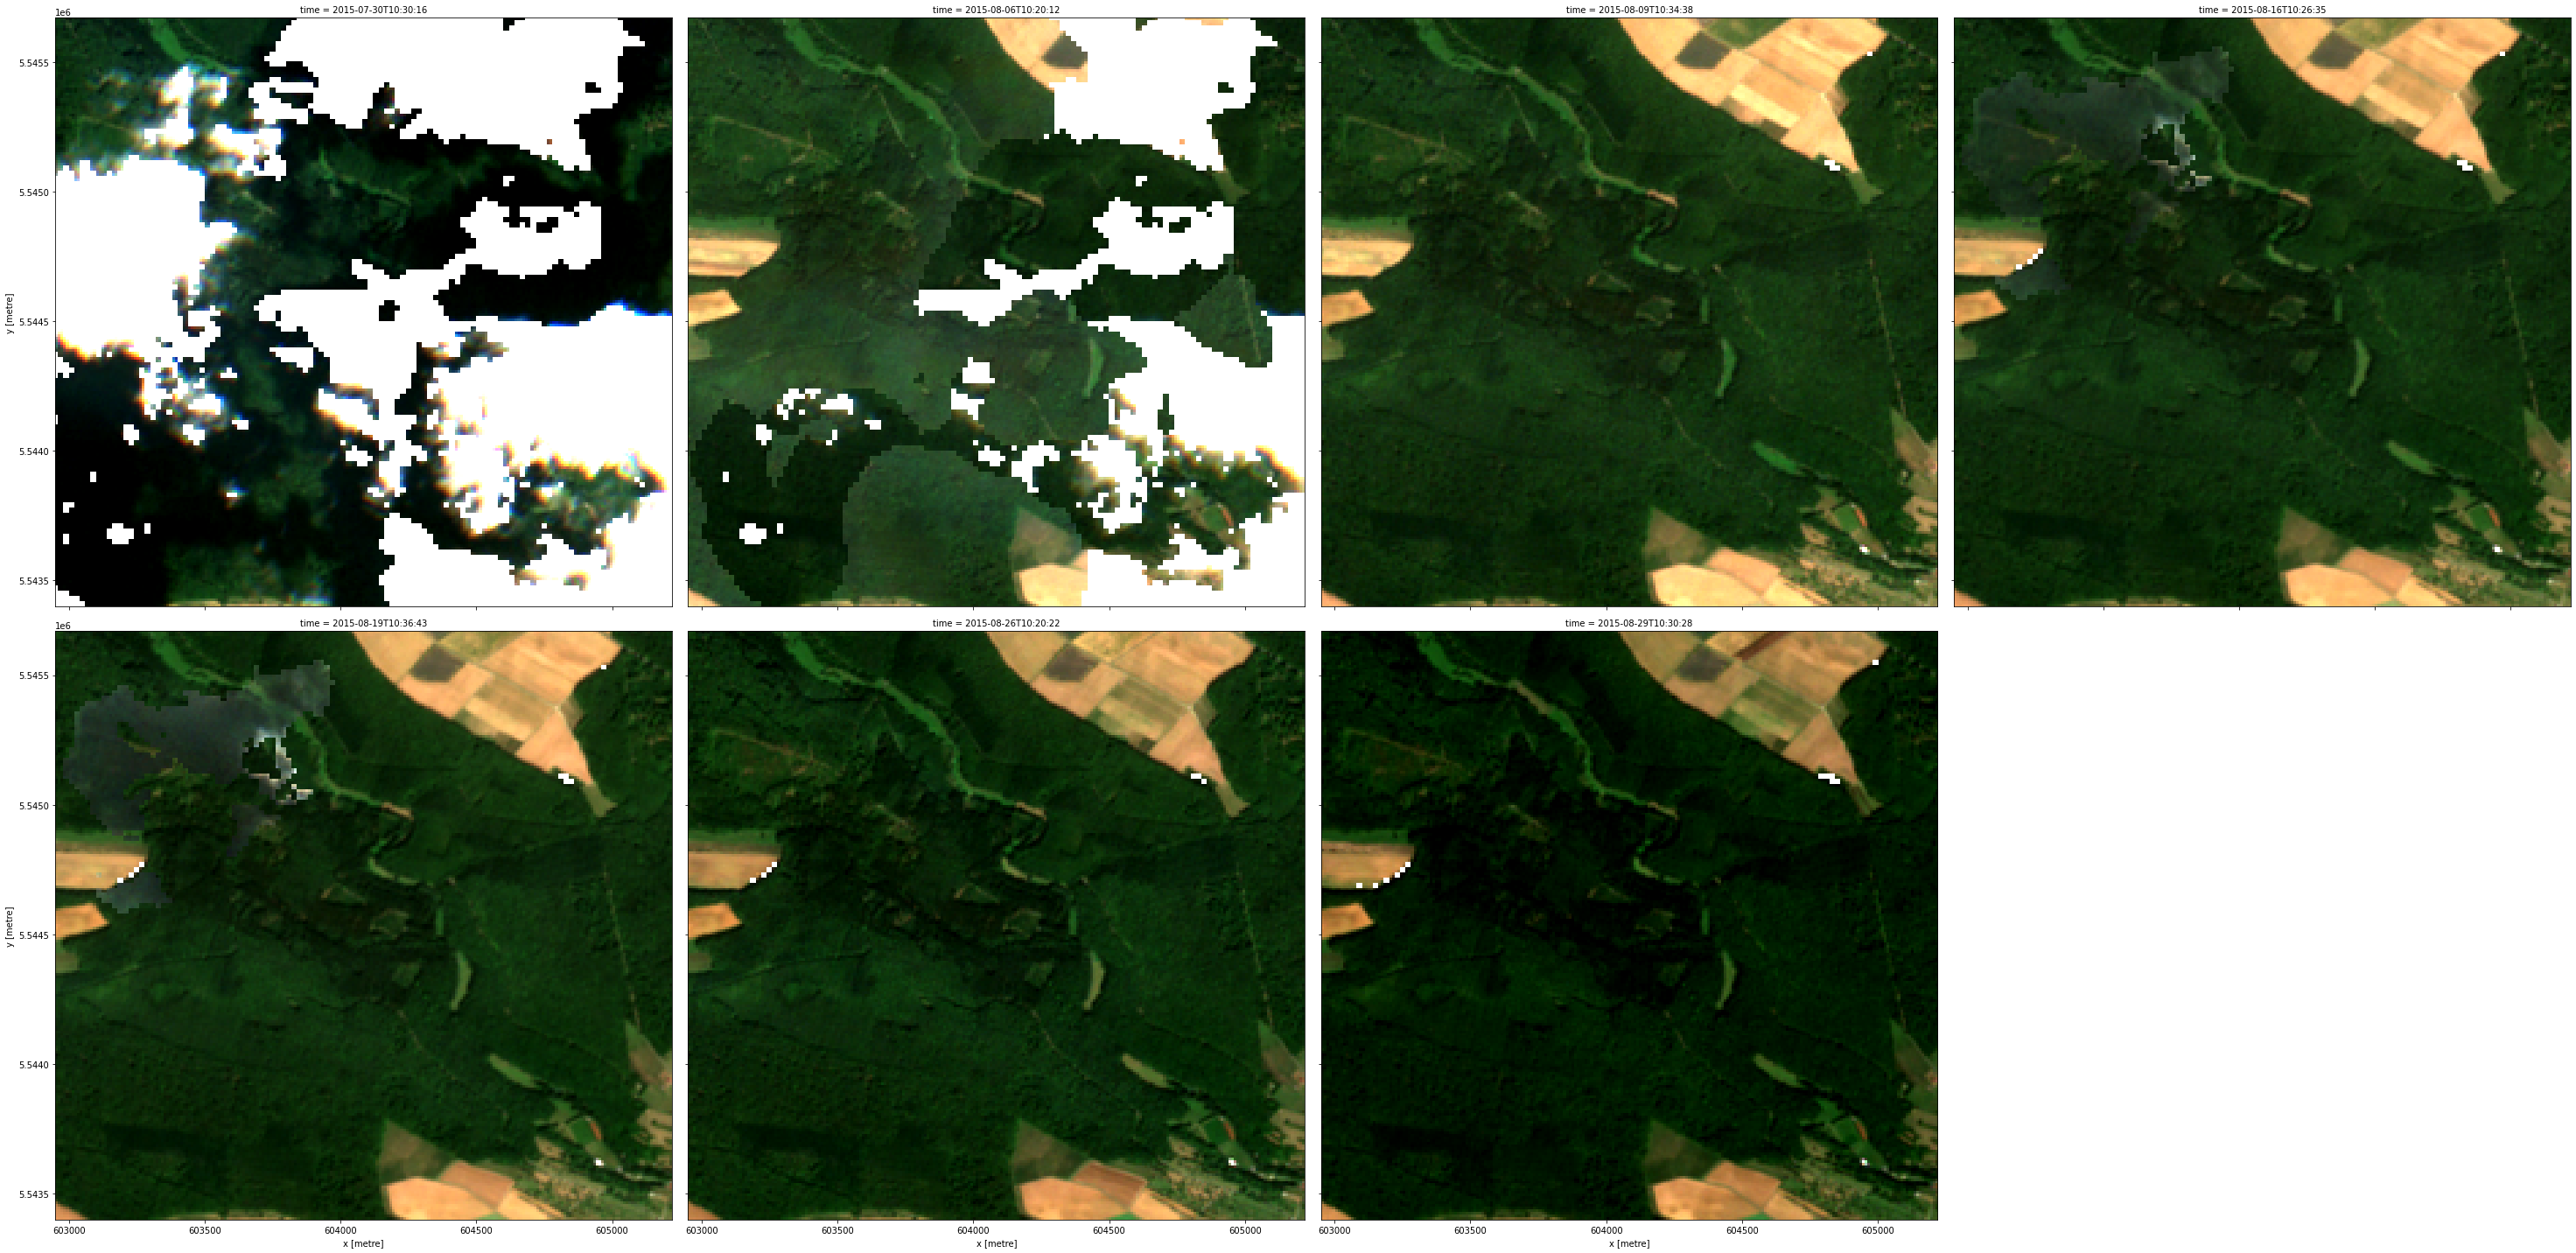

In [177]:
rgb(interclean, index=[0,1,2,3,4,5,6], size = 10, percentile_stretch=(0.11, 0.99))


In [162]:
interclean.red.values[:,0,0]

array([261., 359., 328.,  nan,  nan, 282., 204.])

## Generating median mosaics

In [106]:
start = ('2018-12-01')
end = ('2019-02-28')

In [34]:
sys.path.append('/datacube/data_cube_notebooks/sebastian_foertsch/utils/')

In [35]:
from data_cube_utilities.dc_mosaic import create_median_mosaic
median_composite = create_median_mosaic(dataset.sel(time=slice(start, end)), cloud_mask)

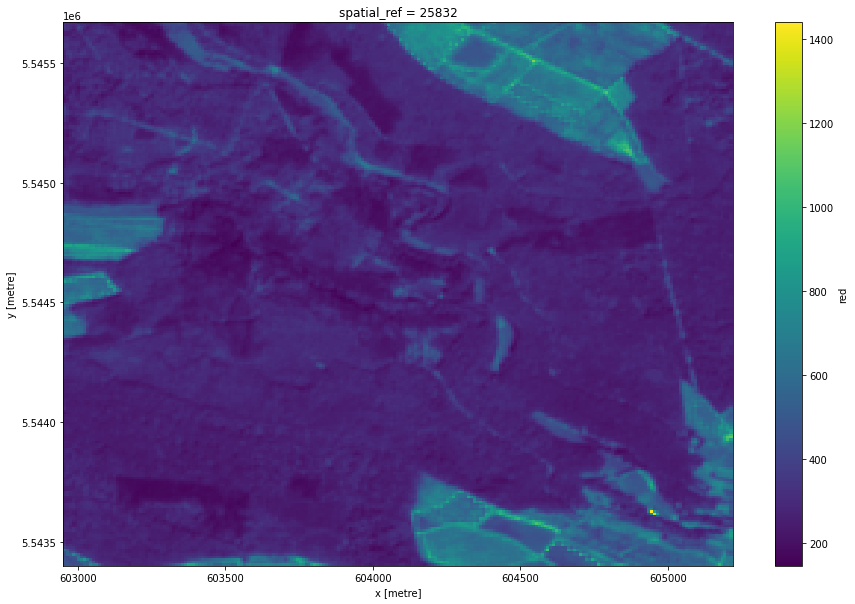

In [74]:
# Plot single bands, with <dataset_name>.<band_name>.plot(size=<integer>)
#median_composite.nir.plot(size=10) # for NIR band
median_composite.red.plot(size=10) #
# ...


In [ ]:
# Plot three-band-composite
# Also try changing the percentile stretch
rgb(median_composite.compute(), bands=['red','green','blue'], percentile_stretch = (0.01,0.99), size = 12)
# False color
#rgb(median_composite, bands=['nir', 'red', 'green'], percentile_stretch = (0.01,0.99), size = 12)

### Animation

In [40]:
# Import required packages
import math
import branca
import folium
import calendar
import ipywidgets
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from pyproj import Proj, transform
from IPython.display import display
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipyleaflet import Map, Marker, Popup, GeoJSON, basemaps, Choropleth
from skimage import exposure
from odc.ui import image_aspect

from matplotlib.animation import FuncAnimation
import pandas as pd
from pathlib import Path
from shapely.geometry import box
from skimage.exposure import rescale_intensity
from tqdm.auto import tqdm
import warnings


In [41]:
def xr_animation(ds,
                 bands=None,
                 output_path='animation.mp4',
                 width_pixels=500,
                 interval=100,                 
                 percentile_stretch=(0.02, 0.98),
                 image_proc_funcs=None,
                 show_gdf=None,
                 show_date='%d %b %Y',
                 show_text=None,
                 show_colorbar=True,
                 gdf_kwargs={},
                 annotation_kwargs={},
                 imshow_kwargs={},
                 colorbar_kwargs={},
                 limit=None):
    
    """
    Takes an `xarray` timeseries and animates the data as either a 
    three-band (e.g. true or false colour) or single-band animation, 
    allowing changes in the landscape to be compared across time.
    
    Animations can be customised to include text and date annotations 
    or use specific combinations of input bands. Vector data can be 
    overlaid and animated on top of imagery, and custom image 
    processing functions can be applied to each frame.
    
    Supports .mp4 (ideal for Twitter/social media) and .gif (ideal 
    for all purposes, but can have large file sizes) format files. 
    
    Last modified: October 2020
    
    Parameters
    ----------  
    ds : xarray.Dataset
        An xarray dataset with multiple time steps (i.e. multiple 
        observations along the `time` dimension).        
    bands : list of strings
        An list of either one or three band names to be plotted, 
        all of which must exist in `ds`. 
    output_path : str, optional
        A string giving the output location and filename of the 
        resulting animation. File extensions of '.mp4' and '.gif' are 
        accepted. Defaults to 'animation.mp4'.
    width_pixels : int, optional
        An integer defining the output width in pixels for the 
        resulting animation. The height of the animation is set 
        automatically based on the dimensions/ratio of the input 
        xarray dataset. Defaults to 500 pixels wide.        
    interval : int, optional
        An integer defining the milliseconds between each animation 
        frame used to control the speed of the output animation. Higher
        values result in a slower animation. Defaults to 100 
        milliseconds between each frame.         
    percentile_stretch : tuple of floats, optional
        An optional tuple of two floats that can be used to clip one or
        three-band arrays by percentiles to produce a more vibrant, 
        visually attractive image that is not affected by outliers/
        extreme values. The default is `(0.02, 0.98)` which is 
        equivalent to xarray's `robust=True`. This parameter is ignored
        completely if `vmin` and `vmax` are provided as kwargs to
        `imshow_kwargs`.
    image_proc_funcs : list of funcs, optional
        An optional list containing functions that will be applied to 
        each animation frame (timestep) prior to animating. This can 
        include image processing functions such as increasing contrast, 
        unsharp masking, saturation etc. The function should take AND 
        return a `numpy.ndarray` with shape [y, x, bands]. If your 
        function has parameters, you can pass in custom values using 
        a lambda function:
        `image_proc_funcs=[lambda x: custom_func(x, param1=10)]`.
    show_gdf: geopandas.GeoDataFrame, optional
        Vector data (e.g. ESRI shapefiles or GeoJSON) can be optionally
        plotted over the top of imagery by supplying a 
        `geopandas.GeoDataFrame` object. To customise colours used to
        plot the vector features, create a new column in the
        GeoDataFrame called 'colors' specifying the colour used to plot 
        each feature: e.g. `gdf['colors'] = 'red'`.
        To plot vector features at specific moments in time during the
        animation, create new 'start_time' and/or 'end_time' columns in
        the GeoDataFrame that define the time range used to plot each 
        feature. Dates can be provided in any string format that can be 
        converted using the `pandas.to_datetime()`. e.g.
         `gdf['end_time'] = ['2001', '2005-01', '2009-01-01']`    
    show_date : string or bool, optional
        An optional string or bool that defines how (or if) to plot 
        date annotations for each animation frame. Defaults to 
        '%d %b %Y'; can be customised to any format understood by 
        strftime (https://strftime.org/). Set to False to remove date 
        annotations completely.       
    show_text : str or list of strings, optional
        An optional string or list of strings with a length equal to 
        the number of timesteps in `ds`. This can be used to display a 
        static text annotation (using a string), or a dynamic title 
        (using a list) that displays different text for each timestep. 
        By default, no text annotation will be plotted.        
    show_colorbar : bool, optional
        An optional boolean indicating whether to include a colourbar 
        for single-band animations. Defaults to True.
    gdf_kwargs : dict, optional
        An optional dictionary of keyword arguments to customise the 
        appearance of a `geopandas.GeoDataFrame` supplied to 
        `show_gdf`. Keyword arguments are passed to `GeoSeries.plot` 
        (see http://geopandas.org/reference.html#geopandas.GeoSeries.plot). 
        For example: `gdf_kwargs = {'linewidth': 2}`. 
    annotation_kwargs : dict, optional
        An optional dict of keyword arguments for controlling the 
        appearance of  text annotations. Keyword arguments are passed 
        to `matplotlib`'s `plt.annotate` 
        (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html 
        for options). For example, `annotation_kwargs={'fontsize':20, 
        'color':'red', 'family':'serif'}.  
    imshow_kwargs : dict, optional
        An optional dict of keyword arguments for controlling the 
        appearance of arrays passed to `matplotlib`'s `plt.imshow` 
        (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html 
        for options). For example, a green colour scheme and custom
        stretch could be specified using: 
        `onebandplot_kwargs={'cmap':'Greens`, 'vmin':0.2, 'vmax':0.9}`.
        (some parameters like 'cmap' will only have an effect for 
        single-band animations, not three-band RGB animations).
    colorbar_kwargs : dict, optional
        An optional dict of keyword arguments used to control the 
        appearance of the colourbar. Keyword arguments are passed to
        `matplotlib.pyplot.tick_params` 
        (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.tick_params.html
        for options). This can be used to customise the colourbar 
        ticks, e.g. changing tick label colour depending on the 
        background of the animation: 
        `colorbar_kwargs={'colors': 'black'}`.
    limit: int, optional
        An optional integer specifying how many animation frames to 
        render (e.g. `limit=50` will render the first 50 frames). This
        can be useful for quickly testing animations without rendering 
        the entire time-series.    
            
    """

    def _start_end_times(gdf, ds):
        """
        Converts 'start_time' and 'end_time' columns in a 
        `geopandas.GeoDataFrame` to datetime objects to allow vector
        features to be plotted at specific moments in time during an
        animation, and sets default values based on the first
        and last time in `ds` if this information is missing from the
        dataset.
        """

        # Make copy of gdf so we do not modify original data
        gdf = gdf.copy()

        # Get min and max times from input dataset
        minmax_times = pd.to_datetime(ds.time.isel(time=[0, -1]).values)

        # Update both `start_time` and `end_time` columns
        for time_col, time_val in zip(['start_time', 'end_time'], minmax_times):

            # Add time_col if it does not exist
            if time_col not in gdf:
                gdf[time_col] = np.nan

            # Convert values to datetimes and fill gaps with relevant time value
            gdf[time_col] = pd.to_datetime(gdf[time_col], errors='ignore')
            gdf[time_col] = gdf[time_col].fillna(time_val)

        return gdf


    def _add_colorbar(fig, ax, vmin, vmax, imshow_defaults, colorbar_defaults):
        """
        Adds a new colorbar axis to the animation with custom minimum 
        and maximum values and styling.
        """

        # Create new axis object for colorbar
        cax = fig.add_axes([0.02, 0.02, 0.96, 0.03])

        # Initialise color bar using plot min and max values
        img = ax.imshow(np.array([[vmin, vmax]]), **imshow_defaults)
        fig.colorbar(img,
                     cax=cax,
                     orientation='horizontal',
                     ticks=np.linspace(vmin, vmax, 2))

        # Fine-tune appearance of colorbar
        cax.xaxis.set_ticks_position('top')
        cax.tick_params(axis='x', **colorbar_defaults)
        cax.get_xticklabels()[0].set_horizontalalignment('left')
        cax.get_xticklabels()[-1].set_horizontalalignment('right')


    def _frame_annotation(times, show_date, show_text):
        """
        Creates a custom annotation for the top-right of the animation
        by converting a `xarray.DataArray` of times into strings, and
        combining this with a custom text annotation. Handles cases 
        where `show_date=False/None`, `show_text=False/None`, or where
        `show_text` is a list of strings.
        """

        # Test if show_text is supplied as a list
        is_sequence = isinstance(show_text, (list, tuple, np.ndarray))

        # Raise exception if it is shorter than number of dates
        if is_sequence and (len(show_text) == 1):
            show_text, is_sequence = show_text[0], False
        elif is_sequence and (len(show_text) < len(times)):
            raise ValueError(f'Annotations supplied via `show_text` must have '
                             f'either a length of 1, or a length >= the number '
                             f'of timesteps in `ds` (n={len(times)})')

        times_list = (times.dt.strftime(show_date).values if show_date else [None] *
                      len(times))
        text_list = show_text if is_sequence else [show_text] * len(times)
        annotation_list = ['\n'.join([str(i) for i in (a, b) if i])
                           for a, b in zip(times_list, text_list)]

        return annotation_list


    def _update_frames(i, ax, extent, annotation_text, gdf, gdf_defaults,
                       annotation_defaults, imshow_defaults):
        """
        Animation called by `matplotlib.animation.FuncAnimation` to 
        animate each frame in the animation. Plots array and any text
        annotations, as well as a temporal subset of `gdf` data based
        on the times specified in 'start_time' and 'end_time' columns.
        """        

        # Clear previous frame to optimise render speed and plot imagery
        ax.clear()
        ax.imshow(array[i, ...].clip(0.0, 1.0), 
                  extent=extent, 
                  vmin=0.0, vmax=1.0, 
                  **imshow_defaults)

        # Add annotation text
        ax.annotate(annotation_text[i], **annotation_defaults)

        # Add geodataframe annotation
        if show_gdf is not None:

            # Obtain start and end times to filter geodataframe features
            time_i = ds.time.isel(time=i).values

            # Subset geodataframe using start and end dates
            gdf_subset = show_gdf.loc[(show_gdf.start_time <= time_i) &
                                      (show_gdf.end_time >= time_i)]           

            if len(gdf_subset.index) > 0:

                # Set color to geodataframe field if supplied
                if ('color' in gdf_subset) and ('color' not in gdf_kwargs):
                    gdf_defaults.update({'color': gdf_subset['color'].tolist()})

                gdf_subset.plot(ax=ax, **gdf_defaults)

        # Remove axes to show imagery only
        ax.axis('off')
        
        # Update progress bar
        progress_bar.update(1)
        
    
    # Test if bands have been supplied, or convert to list to allow
    # iteration if a single band is provided as a string
    if bands is None:
        raise ValueError(f'Please use the `bands` parameter to supply '
                         f'a list of one or three bands that exist as '
                         f'variables in `ds`, e.g. {list(ds.data_vars)}')
    elif isinstance(bands, str):
        bands = [bands]
    
    # Test if bands exist in dataset
    missing_bands = [b for b in bands if b not in ds.data_vars]
    if missing_bands:
        raise ValueError(f'Band(s) {missing_bands} do not exist as '
                         f'variables in `ds` {list(ds.data_vars)}')
    
    # Test if time dimension exists in dataset
    if 'time' not in ds.dims:
        raise ValueError(f"`ds` does not contain a 'time' dimension "
                         f"required for generating an animation")
                
    # Set default parameters
    outline = [PathEffects.withStroke(linewidth=2.5, foreground='black')]
    annotation_defaults = {
        'xy': (1, 1),
        'xycoords': 'axes fraction',
        'xytext': (-5, -5),
        'textcoords': 'offset points',
        'horizontalalignment': 'right',
        'verticalalignment': 'top',
        'fontsize': 20,
        'color': 'white',
        'path_effects': outline
    }
    imshow_defaults = {'cmap': 'magma', 'interpolation': 'nearest'}
    colorbar_defaults = {'colors': 'white', 'labelsize': 12, 'length': 0}
    gdf_defaults = {'linewidth': 1.5}

    # Update defaults with kwargs
    annotation_defaults.update(annotation_kwargs)
    imshow_defaults.update(imshow_kwargs)
    colorbar_defaults.update(colorbar_kwargs)
    gdf_defaults.update(gdf_kwargs)

    # Get info on dataset dimensions
    height, width = ds.geobox.shape
    scale = width_pixels / width
    left, bottom, right, top = ds.geobox.extent.boundingbox

    # Prepare annotations
    annotation_list = _frame_annotation(ds.time, show_date, show_text)

    # Prepare geodataframe
    if show_gdf is not None:
        show_gdf = show_gdf.to_crs(ds.geobox.crs)
        show_gdf = gpd.clip(show_gdf, mask=box(left, bottom, right, top))
        show_gdf = _start_end_times(show_gdf, ds)

    # Convert data to 4D numpy array of shape [time, y, x, bands]
    ds = ds[bands].to_array().transpose(..., 'variable')[0:limit, ...]
    array = ds.astype(np.float32).values

    # Optionally apply image processing along axis 0 (e.g. to each timestep)
    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ({remaining_s:.1f} ' \
                   'seconds remaining at {rate_fmt}{postfix})'
    if image_proc_funcs:
        print('Applying custom image processing functions')
        for i, array_i in tqdm(enumerate(array),
                               total=len(ds.time),
                               leave=False,
                               bar_format=bar_format,
                               unit=' frames'):
            for func in image_proc_funcs:
                array_i = func(array_i)
            array[i, ...] = array_i

    # Clip to percentiles and rescale between 0.0 and 1.0 for plotting
    vmin, vmax = np.quantile(array[np.isfinite(array)], q=percentile_stretch)
        
    # Replace with vmin and vmax if present in `imshow_defaults`
    if 'vmin' in imshow_defaults:
        vmin = imshow_defaults.pop('vmin')
    if 'vmax' in imshow_defaults:
        vmax = imshow_defaults.pop('vmax')
    
    # Rescale between 0 and 1
    array = rescale_intensity(array, 
                              in_range=(vmin, vmax), 
                              out_range=(0.0, 1.0))
    array = np.squeeze(array)  # remove final axis if only one band

    # Set up figure
    fig, ax = plt.subplots()
    fig.set_size_inches(width * scale / 72, height * scale / 72, forward=True)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

    # Optionally add colorbar
    if show_colorbar & (len(bands) == 1):
        _add_colorbar(fig, ax, vmin, vmax, imshow_defaults, colorbar_defaults)

    # Animate
    print(f'Exporting animation to {output_path}') 
    anim = FuncAnimation(
        fig=fig,
        func=_update_frames,
        fargs=(
            ax,  # axis to plot into
            [left, right, bottom, top],  # imshow extent
            annotation_list,  # list of text annotations
            show_gdf,  # geodataframe to plot over imagery
            gdf_defaults,  # any kwargs used to plot gdf
            annotation_defaults,  # kwargs for annotations
            imshow_defaults),  # kwargs for imshow
        frames=len(ds.time),
        interval=interval,
        repeat=False)
    
    # Set up progress bar
    progress_bar = tqdm(total=len(ds.time), 
                        unit=' frames', 
                        bar_format=bar_format) 

    # Export animation to file
    if Path(output_path).suffix == '.gif':
        anim.save(output_path, writer='pillow')
    else:
        anim.save(output_path, dpi=72)

    # Update progress bar to fix progress bar moving past end
    if progress_bar.n != len(ds.time):
        progress_bar.n = len(ds.time)
        progress_bar.last_print_n = len(ds.time)

In [ ]:
xr_animation(ds,
                 bands=None,
                 output_path='animation.mp4',
                 width_pixels=500,
                 interval=100,                 
                 percentile_stretch=(0.02, 0.98),
                 image_proc_funcs=None,
                 show_gdf=None,
                 show_date='%d %b %Y',
                 show_text=None,
                 show_colorbar=True,
                 gdf_kwargs={},
                 annotation_kwargs={},
                 imshow_kwargs={},
                 colorbar_kwargs={},
                 limit=None):

Exporting animation to animation.mp4


  0%|          | 0/935 (0.0 seconds remaining at ? frames/s)

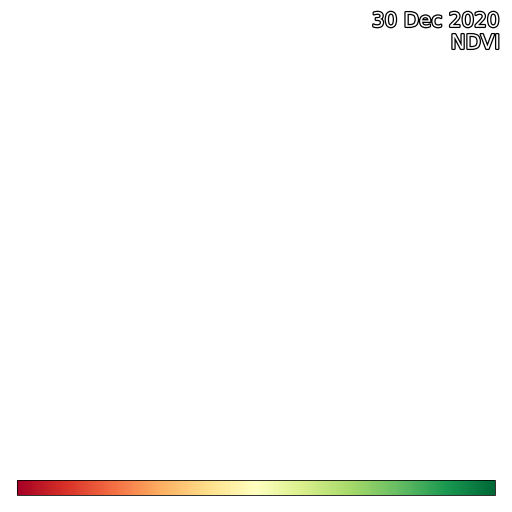

In [70]:
xr_animation(ds=cleaned_dataset,bands=['ndvi8'], show_text = 'NDVI',
            colorbar_kwargs={'colors':'white','size':10}, interval=75,
            imshow_kwargs={'cmap':'RdYlGn','vmin':0,'vmax':1})

## Mosaic

In [73]:
from data_cube_utilities.dc_mosaic import create_median_mosaic
median_composite = create_median_mosaic(cleaned_dataset)

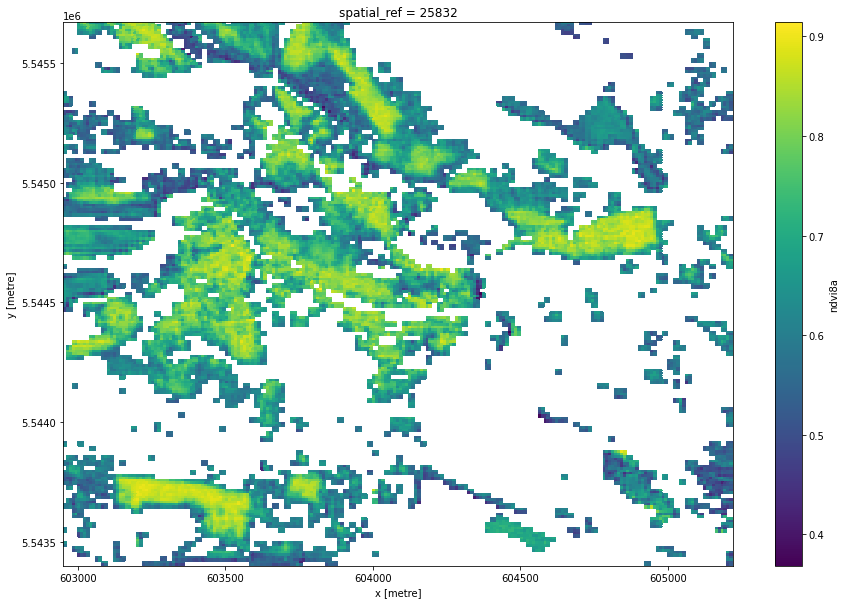

In [83]:
# Plot single bands, with <dataset_name>.<band_name>.plot(size=<integer>)
#median_composite.nir.plot(size=10) # for NIR band
median_composite.ndvi8a.plot(size=10) # 
# ...


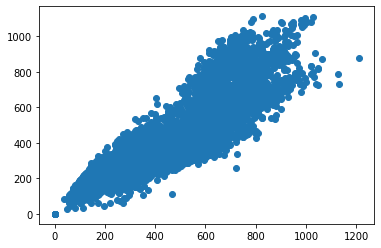

In [89]:
plt.scatter(median_composite.red, median_composite.green)

## Export to cloud optimized geotiff (cog)

In [78]:
from datacube.utils.cog import write_cog
lazy_ds = write_cog(geo_im=median_composite.to_array(), 
                       fname='dask_geotiff01.tif',
                       overwrite=True)
lazy_ds.compute()

PosixPath('dask_geotiff01.tif')